In [2]:
import CMGDB
import math
import matplotlib
import numpy as np

### Lake model

In [3]:
def ives_model(x: np.ndarray,
               r1: float = 3.873,
               r2: float = 11.746,
               c: float = 10**-6.435,
               d: float = 0.5517,
               p: float = 0.06659,
               q: float = 0.9026) -> np.ndarray:
    """
    Ives et al. (2008) midge-algae-detritus ecological model.

    A discrete-time ecological model capturing the dynamics of midges, algae,
    and detritus in Lake Myvatn. The model exhibits complex dynamics including
    multiple stable states and regime shifts.

    Equations:
        midge_{n+1} = r1 * midge_n * (1 + midge_n / resource)^(-q)
        algae_{n+1} = r2 * algae_n / (1 + algae_n) - algae_consumed + c
        detritus_{n+1} = d * detritus_n + algae_n - detritus_consumed + c
    where:
        resource = algae_n + p * detritus_n
        algae_consumed = (algae_n / resource) * midge_{n+1}
        detritus_consumed = (p * detritus_n / resource) * midge_{n+1}

    Args:
        x: State vector [midge, algae, detritus] (all non-negative)
        r1: Midge reproduction rate (default: 3.873)
        r2: Algae growth rate (default: 11.746)
        c: Constant input of algae and detritus (default: 10^-6.435)
        d: Detritus decay rate (default: 0.5517)
        p: Relative palatability of detritus (default: 0.06659)
        q: Exponent in midge consumption (default: 0.902)

    Returns:
        Next state vector [midge, algae, detritus]

    Reference:
        Ives, A.R., et al., "High-amplitude fluctuations and alternative
        dynamical states of midges in Lake Myvatn"
        Nature 452: 84-87 (2008)

    Example:
        >>> from MorseGraph.systems import ives_model
        >>> x = np.array([0.23, 0.08, 0.49])  # Near stable point
        >>> x_next = ives_model(x)
    """
    midge, algae, detritus = x[0], x[1], x[2]

    # Enforce non-negativity
    midge = max(0, midge)
    algae = max(0, algae)
    detritus = max(0, detritus)

    # Compute resource availability
    resource = algae + p * detritus

    # Midge dynamics
    if resource <= 1e-12:
        midge_next = 0
        algae_consumed = 0
        detritus_consumed = 0
    else:
        midge_next = r1 * midge * (1 + midge / resource)**(-q)
        algae_consumed = (algae / resource) * midge_next
        detritus_consumed = (p * detritus / resource) * midge_next

    # Algae dynamics
    algae_produced = r2 * algae / (1 + algae)
    algae_next = algae_produced - algae_consumed + c
    if algae_next < c:
        algae_next = c

    # Detritus dynamics
    detritus_next = d * detritus + algae - detritus_consumed + c
    if detritus_next < c:
        detritus_next = c

    return np.array([midge_next, algae_next, detritus_next])

In [4]:
# Define box map for f
def F(rect):
    return CMGDB.BoxMap(ives_model, rect)

In [25]:
lower_bounds = [0.0, 0.0, 0.0]
upper_bounds = [1000.0, 1000.0, 1000.0]

subdiv_min = 51 # 30
subdiv_max = 60 # 36 # 40
subdiv_init = 0 # 18
subdiv_limit = 1000000

model = CMGDB.Model(subdiv_min, subdiv_max, subdiv_init, subdiv_limit, lower_bounds, upper_bounds, F)

In [26]:
%%time
morse_graph, map_graph = CMGDB.ComputeMorseGraph(model)

CPU times: user 11min 15s, sys: 3.35 s, total: 11min 18s
Wall time: 11min 19s


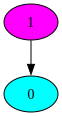

In [27]:
CMGDB.PlotMorseGraph(morse_graph, cmap=matplotlib.cm.cool)

In [28]:
# CMGDB.PlotMorseSets3D(morse_graph,cmap=matplotlib.cm.cool)

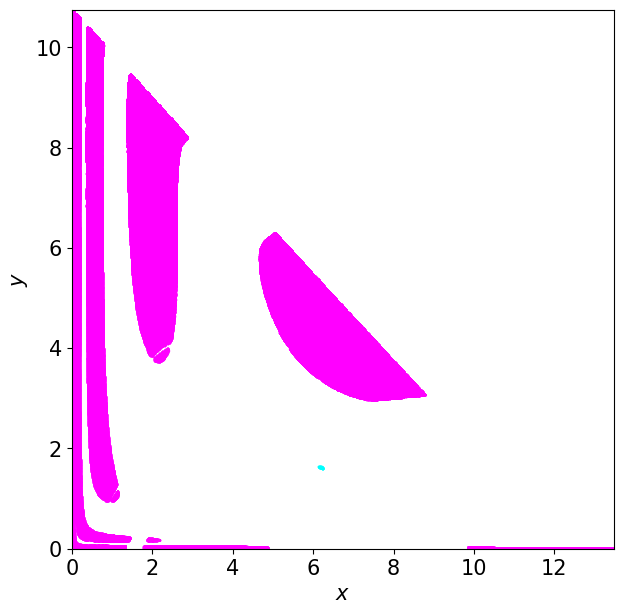

In [29]:
CMGDB.PlotMorseSets(morse_graph, cmap=matplotlib.cm.cool, fig_w=7, fig_h=7)

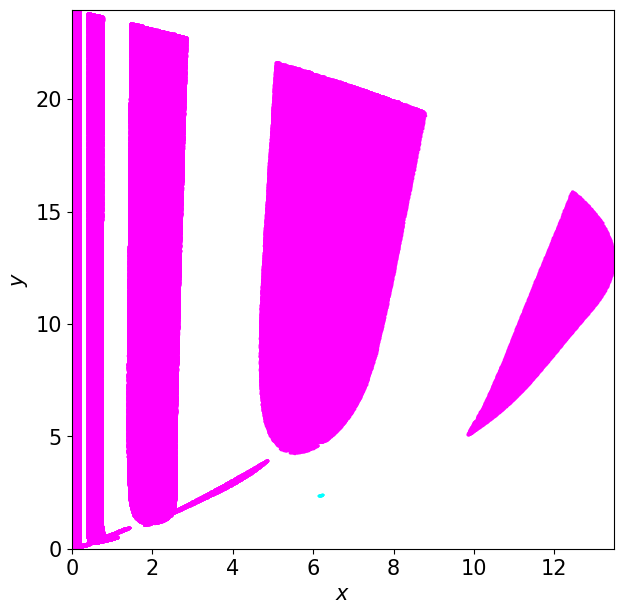

In [30]:
CMGDB.PlotMorseSets(morse_graph, cmap=matplotlib.cm.cool, proj_dims=[0, 2], fig_w=7, fig_h=7)

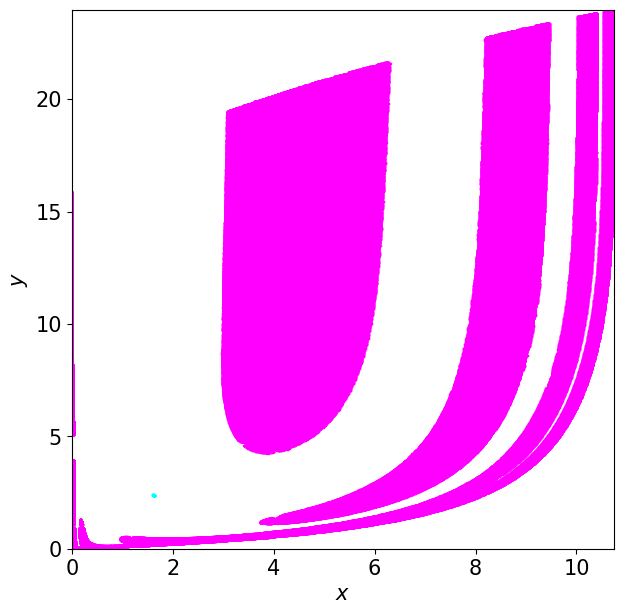

In [31]:
CMGDB.PlotMorseSets(morse_graph, cmap=matplotlib.cm.cool, proj_dims=[1, 2], fig_w=7, fig_h=7)